In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [3]:
os.chdir('../')

<IPython.core.display.Javascript object>

In [4]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
)

from src.train import lightGBM

<IPython.core.display.Javascript object>

## Using machine learning to detect credit card fraud


### Introduction

The aim of this project is to train a machine learning model to detect fraudulent 
credit card transactions. Building a robust models is important for protecting customers
from purchases they did not make.

### About the data

The dataset is credited to the Machine Learning Group and Andrea Dal Pozzolo. As seen below, 
the CSV file contains a number of anomynous variables (V1,V2,...), along with **Time** and **Amount**.


In [5]:
df = pd.read_csv('./data/creditcard.csv')
# total transaction
total_trans = df.shape[0]

print(df.shape)
df.head(5)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<IPython.core.display.Javascript object>

Here, the label for the dataset is found in the **Class** column (where fraudulent transactions have class=1). The features are **Time**, **Amount**, **V1**, **V2** and so on. These features are principal components of some variables obtained from PCA. 
We don't know what the original variables for these PCA are, as those data are confidential. But we have two known variables, which are **Time** and **Amount**.

Essentially, the idea here is that a combination of these features will indicate whether a particular transaction
is a fraudulent or not. We can use a supervised learning algorithms as the labels have already been defined. If the labels are not given, we can try to use PCA + K mean clustering to create labels (i.e. identify a subset of suspicious 
transactions) for the dataset.

### Data Cleaning

There are a couple of things we want to do there. 

**FIRST:** The **Time** column isn't that useful for machine learning models, as it appears to just be increasing with each transaction row. So essentially we can just remove this column.

**SECOND:** Looking at the **Amount** column, the values have a wide range, which means that the model might take
a long time to converge to a solution. If we normalize this column, it will help the model train faster.

**THIRD:** We need to check to see if there are any null in the dataset and remove any duplicate data.


In [6]:
from sklearn.preprocessing import StandardScaler


################# drop Time column #####################
try:
    df.drop(labels=["Time"], axis=1, inplace=True)
except:
    print("Time column has already been removed")


########### normalize the Amount column ###############

# create a 2d array of the amounts
amounts = df.Amount.values[:, np.newaxis]
# # scale the data so that the mean = 0 and sigma = 1
# scaler = StandardScaler()
# scaled_amounts = scaler.fit_transform(amounts)
# df["Amount"] = scaled_amounts


########### remove NANs and duplicates ###############
# see if there is any null values in each column
print(df.info())  # this shows that there are no null values

print(f'The number of null values in dataset is {df.isnull().sum().sum()}')

# drop duplications (by default this code checks for duplicated values across all columns)
df.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

<IPython.core.display.Javascript object>

In [7]:
print(f"The number of duplicated values is {total_trans - df.shape[0]}")
print(f"The total number of (non-dupl) transactions are: {df.shape[0]}")
print(f"The number of fraudulent transactions are: {len(df[df.Class == 1])}")
print(f"The number of non-fraud transactions are: {len(df[df.Class == 0])}")


The number of duplicated values is 9144
The total number of (non-dupl) transactions are: 275663
The number of fraudulent transactions are: 473
The number of non-fraud transactions are: 275190


<IPython.core.display.Javascript object>

We have removed around 9000 duplicated transactions. After this, only a small number of transactions are fraudalent.


### Training the model

To begin, we want to separate dataset into a training set and a testing set.

In [7]:
from sklearn.model_selection import train_test_split

# defining the feature columns and the label columns
feat = df.drop("Class", axis=1).values
labels = df["Class"].values

# separating the data into a training set and a testing set (0.3 of the total data)
feat_train, feat_test, labels_train, labels_test = train_test_split(
    feat, labels, test_size=0.3, random_state=0
)

print(f"The size of the training set is: {labels_train.shape[0]}")


The size of the training set is: 192964


<IPython.core.display.Javascript object>


In this particular example, the generalized idea here is that a set of features (i.e., Amount, V1, V2 ...) will tell us whether a transaction is fraud or not. If we use a decision tree, a structured branch is made based on the features so that the model can transverse it to figure out whether subsets of the features correspond to the fraud/non-fraud class.


In [8]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(feat_train,labels_train)

labels_pred = clf.predict(feat_test)

<IPython.core.display.Javascript object>

### Testing model's accuracy

A good way to gauge how well the model can classify fraudulent transactions from the testing set is to create a confusion matrix. Essentially, the diagonal of the matrix will tell you how many correct labels the model made, while the off-diagonal tells you the number of false negative and false positive.

However, what we are interested in is the number of credit card fraudulent cases which are mislabeled by the model (false negative). If a lot of fraud cases are falsely labeled as non-fraud, it would indicate that then the model is not effective at all.


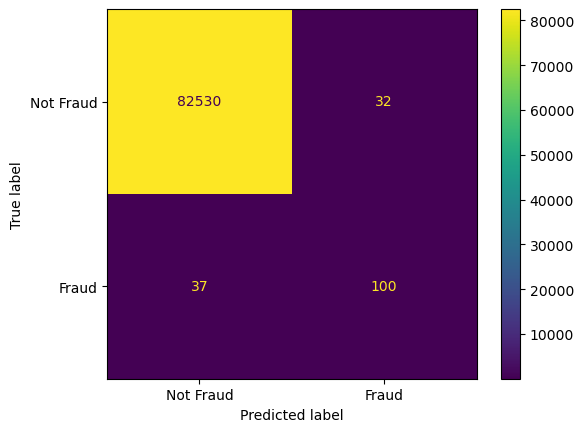

The total number of fraudulent transactions are: 137
The number of fraudulent transactions which are falsely labeled are: 37
Recall: 0.73
Precision: 0.76
F1-score: 0.74


<IPython.core.display.Javascript object>

In [9]:
# confusion matrix
cm = confusion_matrix(labels_test, labels_pred)
tn, fp, fn, tp = cm.ravel()


cmd_obj = ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"])
cmd_obj.plot()
plt.show()

print(f"The total number of fraudulent transactions are: {fn + tp}")
print(f"The number of fraudulent transactions which are falsely labeled are: {fn}")

print(f"Recall: {recall_score(labels_test, labels_pred).round(2)}")
print(f"Precision: {precision_score(labels_test, labels_pred).round(2)}")
print(f"F1-score: {f1_score(labels_test, labels_pred).round(2)}")


As you can see, **only 73%** of all fraud transactions are correctly predicted by the model, while **76%** of all predicted fraud transactions are correct.

### Using an ensemble of decision trees (LightGBM)

Above, only a single decision tree is made, which is not sufficient for an effective model. However, we can push this tree model idea a bit further by using an ensemble of trees. The idea is similar, but instead of making one decisison tree, we now rely on multiple trees for random subsets. I implemented LightGBM as it is faster compared to xgboost and offere similar accuracy.

We can train this new model to see how well it compares to a single decision tree. 

In [6]:
from src.train import lightGBM

best_params, results, y_pred, y_test = lightGBM()

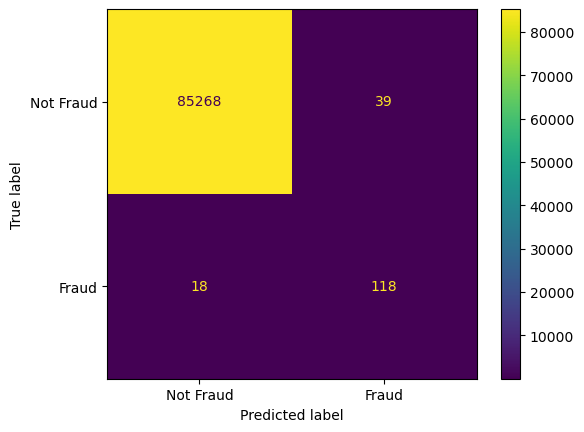

Recall: 0.87
Precision: 0.75
F1-score: 0.81


<IPython.core.display.Javascript object>

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display confusion matrix
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
cmd_obj.plot()
plt.show()

print(f"Recall: {recall_score(y_test, y_pred).round(2)}")
print(f"Precision: {precision_score(y_test, y_pred).round(2)}")
print(f"F1-score: {f1_score(y_test, y_pred).round(2)}")


So we can see that we have improved the recall of the model by quite a lot. In fact, this improvement comes with little loss to the precision. This means that we are less likely to falsely flagged a non-fraud transaction. 

We could try to improve on both the recall and precision further. To do this, we need to deal with the **imbalanced nature of the dataset**, as the majority of the labels are non-fraud (>20000) and a minority of the labels are fraud (<500). 

We can try to use sampling techniques to try to balance out the two labels. Here, SMOTE is a resampling technique from the Python library **imbalance-learned**. It samples the minority class to generate synethic observations of fraudulent transactions. We can see at the end, both the metric for the recall and precision is close to zero, indicating the model is very effective.

In [8]:
best_params, results, y_pred, y_test = lightGBM(resample="SMOTEENN")

Applying resampling technique...
Starting to search for optimal params...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates,

<IPython.core.display.Javascript object>

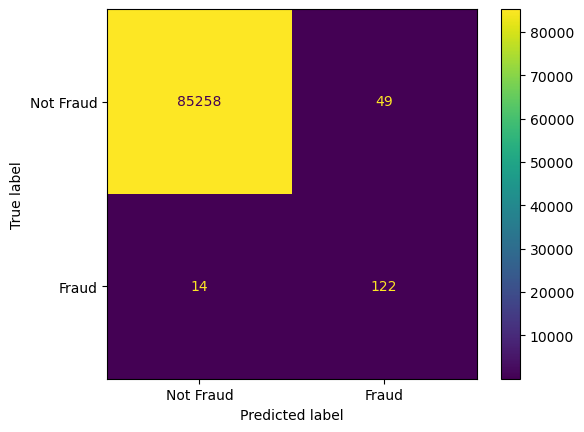

Recall: 0.9
Precision: 0.71
F1-score: 0.79


<IPython.core.display.Javascript object>

In [9]:
cm = confusion_matrix(y_test, y_pred)

# display confusion matrix
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Not Fraud', 'Fraud'])
cmd_obj.plot()
plt.show()

# print metrics
print(f"Recall: {recall_score(y_test, y_pred).round(2)}")
print(f"Precision: {precision_score(y_test, y_pred).round(2)}")
print(f"F1-score: {f1_score(y_test, y_pred).round(2)}")
